IMPORT LIBRARIES

In [84]:

!pip install tweet-preprocessor
!pip install tweepy
import tweepy
import re
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import preprocessor as p
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
import spacy
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import os
import matplotlib.pyplot as plt


EXTRACT TWEETS 

(1094, 5)


In [107]:
df=pd.read_csv('SentimentSample.csv')
df=df.drop(df.columns[0],axis=1)


,id,tweet,place,place_coord_boundaries,location
0,1.379175e+18,Why are hashtags always spelt incorrectly?,en,NaN,London
1,1.379174e+18,health regulator may restrict shot for younger...,en,NaN,Barquisimeto-Venezuela
2,1.379172e+18,VIDEO The effects of the four vaccines current...,en,NaN,Somalia
3,1.379171e+18,s vaccine roll out is the biggest joke in the ...,en,NaN,"Alberta, canada"
4,1.379169e+18,My point was that if Germany gets that many ja...,en,NaN,Birmingham


In [109]:

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
df['tweet']=df['tweet'].apply(p.clean)

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


In [110]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [111]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

X = df['tweet'] # the features we want to analyze
ylabels = df['Target'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [112]:
from sklearn import metrics
def LR_class():
  LR_classifier = LogisticRegression( max_iter=10000)

# Create pipeline using Bag of Words
  pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', LR_classifier)])

  # model generation
  pipe.fit(df['tweet'],df['Target'])
  predicted = pipe.predict(X_test)
  print('Logistic Regression with BOW',metrics.accuracy_score(y_test, predicted))
  df_tweepy['Predicted']=predicted
  df_tweepy.head()
  pipe = Pipeline([("cleaner", predictors()),
                   ('vectorizer', tfidf_vector),
                   ('classifier', LR_classifier)])
  pipe.fit(X_train,y_train)
  predicted = pipe.predict(X_test)
  print('Logistic Regression with TF-IDF',metrics.accuracy_score(y_test, predicted))



In [26]:
def RandomForest():
  rf_model = RandomForestClassifier()
  pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', rf_model)])
  pipe.fit(X_train,y_train)
  predicted = pipe.predict(X_test)
  print('RF  with TF-IDF', metrics.accuracy_score(predicted, y_test))
  # pipe.score(X_test, y_test)


RF  with TF-IDF 0.7289770354906054


In [27]:
#estimators=[(‘rf’, rf_model),(‘log_reg’,classifier)]


In [28]:
# 
def NaiveBayes():
  nb_clf = MultinomialNB()
  pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', nb_clf)])
  pipe.fit(X_train,y_train)
  predicted = pipe.predict(X_test)
  print('Naive Bayes with TF-IDF', metrics.accuracy_score(predicted, y_test))
  pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', nb_clf)])
  pipe.fit(X_train,y_train)
  predicted = pipe.predict(X_test)
  print('Naive  with BOW', metrics.accuracy_score(predicted, y_test))

Naive Bayes with TF-IDF 0.737286012526096
Naive  with BOW 0.7388726513569938


In [29]:
#Import svm model
from sklearn import svm
def SVM();
#Create a svm Classifier
  svm_clf = svm.SVC(kernel='linear') # Linear Kernel

  pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', svm_clf)])
  pipe.fit(X_train,y_train)
  print('SVM with TF-IDF',pipe.score(X_test, y_test))

  pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', svm_clf)])
  pipe.fit(X_train,y_train)
  print('SVM with BOW', pipe.score(X_test, y_test))


In [30]:
from sklearn.ensemble import  VotingClassifier
def EnsembleClass():
  #svm_clf = svm.SVC(kernel='linear',probability=False)
  nb_clf = MultinomialNB()
  LR_classifier = LogisticRegression( max_iter=10000)
  rf_clf = RandomForestClassifier()
  ensemble= VotingClassifier(estimators=[('lr', nb_clf), ('gnb', LR_classifier),('rf',rf_clf)],voting='soft')
  #ensemble = VotingClassifier(estimators, voting=’hard’)
  pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', ensemble)])

  #fit model to training data
  pipe.fit(X_train, y_train)
  predicted = pipe.predict(X_test)
  print('Ensemble  with TF-IDF', metrics.accuracy_score(predicted, y_test))
  pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', ensemble)])

#fit model to training data
  pipe.fit(X_train, y_train)
  predicted = pipe.predict(X_test)
  print('Ensemble  with BOW', metrics.accuracy_score(predicted, y_test))
  # #test our model on the test data
  # pipe.score(X_test, y_test)

Naive  with BOW 0.7497703549060543


In [122]:
def special(text):
  return re.sub('[^A-Za-z0-9]+', '', text)

def tweet_scraper(keyword, file):
  #KEY Provided by Twitter to devs
  COLS =  ['id','tweet','place', 'place_coord_boundaries','location']
  consumer_key = 'l7eh1EjkkwkkzNAFOu9to0u5H'
  consumer_secret = 'Zl4SEs3fQbzuf4F8bmVZjdSnrQg4uh9tFymjae0UjmzpkYs8DP'
  access_key= '458521290-LQE7dnynUpAjbFhhWWadobhoWrcQNanC8nkcLD0Y'
  access_secret = 'hbqTfGtkXyel0OzLu6ZQqbvEIgbp1mryDqRIJFnQHiQBd'
  # Creating an OAuth Client connection
  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_key, access_secret)
  #Using Tweepy API
  api = tweepy.API(auth)
  

#If File already exits then overwrite tweets in same file else declare new 
  if os.path.exists(file):
    df = pd.read_csv(file, header=0)
  else:
    df = pd.DataFrame(columns=COLS)
  #Calling Tweepy API (excluding Retweets )
  for page in tweepy.Cursor(api.search, q=keyword+'-filter:retweets',count=200, include_rts=False,wait_on_rate_limit=True).pages(500):
    for status in page:
      new_entry = []
      status = status._json
      bad_chars = [';', ':', '!', "*"]     
      if status['lang'] == 'en':    #Filtering out based on language
        #status['text'] = re.sub('[^A-Za-z0-9]+', '',status['text'])
        for i in bad_chars :
          status['text'] =status['text'].replace(i, '')
        status['text'] = re.sub(r'[^\x00-\x7F]+',' ', status['text'])
        status['text'] = re.sub(r"won\'t", "will not", status['text'])
        status['text'] = re.sub(r"can\'t", "can not", status['text'])
        status['text'] = re.sub(r"cant", "can not", status['text'])
        status['text'] = re.sub(r"y'all", "you all", status['text'])
    # general
        status['text'] = re.sub(r"n\'t", " not", status['text'])
        status['text'] = re.sub(r"\'re", " are", status['text'])
        status['text'] = re.sub(r"\'s", " is", status['text'])   #using regular expressions to expand the contractions
        status['text'] = re.sub(r"\'d", " would", status['text'])
        status['text'] = re.sub(r"\'ll", " will", status['text'])
        status['text'] = re.sub(r"\'t", " not", status['text'])
        status['text'] = re.sub(r"\'ve", " have", status['text'])
        status['text'] = re.sub(r"\'m", " am", status['text'])
        status['text'] = re.sub(r"\'scuse", " excuse ", status['text'])
        
        
        new_entry += [float((status['id'])),status['text'],status['lang']]
        try:
          coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
        except TypeError:
          coordinates = None
        new_entry.append(coordinates)
        
        try:
          location = status['user']['location']
        except TypeError:
          location = ''
        new_entry.append(location)
        single_tweet_df = pd.DataFrame([new_entry], columns=COLS)  
        df = df.append(single_tweet_df)
        new_entry.clear()
  df = df.drop_duplicates(subset=['id'], keep='last')
  df_tweepy=df.copy()
  df_tweepy.to_csv(keyword+'.csv', mode='a', columns=COLS, index=False, encoding="utf-8")  

In [ ]:
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', LR_classifier)])

# model generation
pipe.fit(df['tweet'],df['Target'])

(1102, 5)


Text(0, 0.5, 'Frequency')

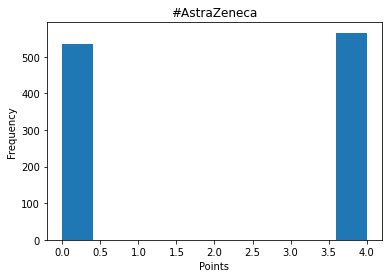

In [117]:
Vaccine_tweets = "AstraZeneca.csv"
vaccine_keywords = '#AstraZeneca'
tweet_scraper(vaccine_keywords, Vaccine_tweets)
df_tweepy=pd.DataFrame()
df_tweepy=pd.read_csv(vaccine_keywords+'.csv')
df_tweepy['tweet']=df_tweepy['tweet'].apply(p.clean)

predicted = pipe.predict(df_tweepy['tweet'])

df_tweepy['Predicted']=predicted

# create figure and axis
fig, ax = plt.subplots()
# plot histogram
ax.hist(df_tweepy['Predicted'])
# set title and labels
ax.set_title(vaccine_keywords)
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')

(2682, 5)


Text(0, 0.5, 'Frequency')

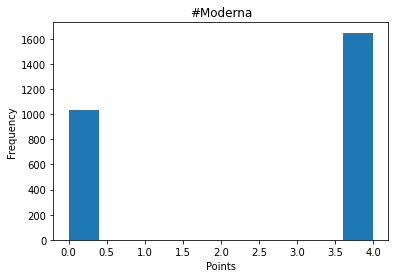

In [118]:
Vaccine_tweets = "Moderna.csv"
vaccine_keywords = '#Moderna'
tweet_scraper(vaccine_keywords, Vaccine_tweets)
df_tweepy=pd.read_csv(vaccine_keywords+'.csv')
df_tweepy['tweet']=df_tweepy['tweet'].apply(p.clean)

predicted = pipe.predict(df_tweepy['tweet'])

df_tweepy['Predicted']=predicted

# create figure and axis
fig, ax = plt.subplots()
# plot histogram
ax.hist(df_tweepy['Predicted'])
# set title and labels
ax.set_title(vaccine_keywords)
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')

In [ ]:
Vaccine_tweets = "Sputnik.csv"
vaccine_keywords = '#Sputnik'
tweet_scraper(vaccine_keywords, Vaccine_tweets)
df_tweepy=pd.read_csv(vaccine_keywords+'.csv')
df_tweepy['tweet']=df_tweepy['tweet'].apply(p.clean)

predicted = pipe.predict(df_tweepy['tweet'])

df_tweepy['Predicted']=predicted

# create figure and axis
fig, ax = plt.subplots()
# plot histogram
ax.hist(df_tweepy['Predicted'])
# set title and labels
ax.set_title(vaccine_keywords)
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')


(2383, 5)


Text(0, 0.5, 'Frequency')

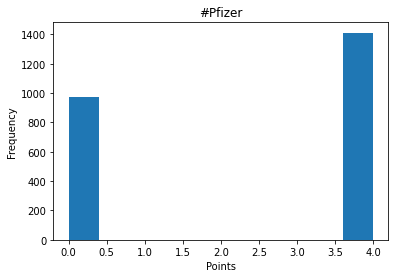

In [121]:
Vaccine_tweets = "Pfizer.csv"
vaccine_keywords = '#Pfizer'
tweet_scraper(vaccine_keywords, Vaccine_tweets)
df_tweepy=pd.read_csv(vaccine_keywords+'.csv')
df_tweepy['tweet']=df_tweepy['tweet'].apply(p.clean)

predicted = pipe.predict(df_tweepy['tweet'])

df_tweepy['Predicted']=predicted

# create figure and axis
fig, ax = plt.subplots()
# plot histogram
ax.hist(df_tweepy['Predicted'])
# set title and labels
ax.set_title(vaccine_keywords)
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')
